In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

rs = 42 # random state
torch.manual_seed(rs)  # torch random state

from joblib import dump


# Dataset overview

In [21]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")
df_raw = df_raw.drop(columns=['id'])
display(df_raw.head())
print("Dataset statistics:")
display(df_raw.describe())

#sns.pairplot(df_raw, hue='stroke')
plt.show()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Dataset statistics:


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


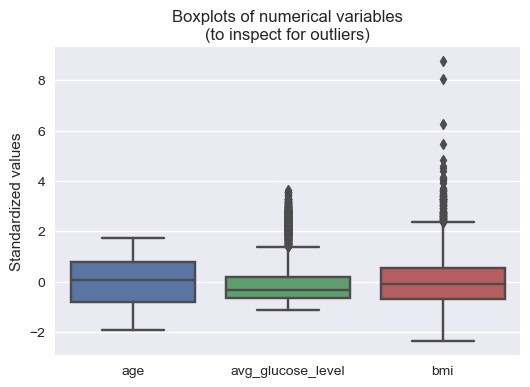

In [22]:
plt.figure(figsize=(6, 4))
scaler = StandardScaler() # first standardize the data to make the boxplots comparable
ax = sns.boxplot(data=scaler.fit_transform(df_raw[['age', 'avg_glucose_level', 'bmi']]))
ax.set_xticklabels(['age', 'avg_glucose_level', 'bmi'])
plt.title("Boxplots of numerical variables\n(to inspect for outliers)")
plt.ylabel("Standardized values")
plt.show()

In [23]:
# Initial correlation plot (this excludes categorical variables since they are not encoded yet)
plt.figure(figsize=(6, 4))
corr = df_raw.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")
plt.show()

ValueError: could not convert string to float: 'Male'

<Figure size 600x400 with 0 Axes>

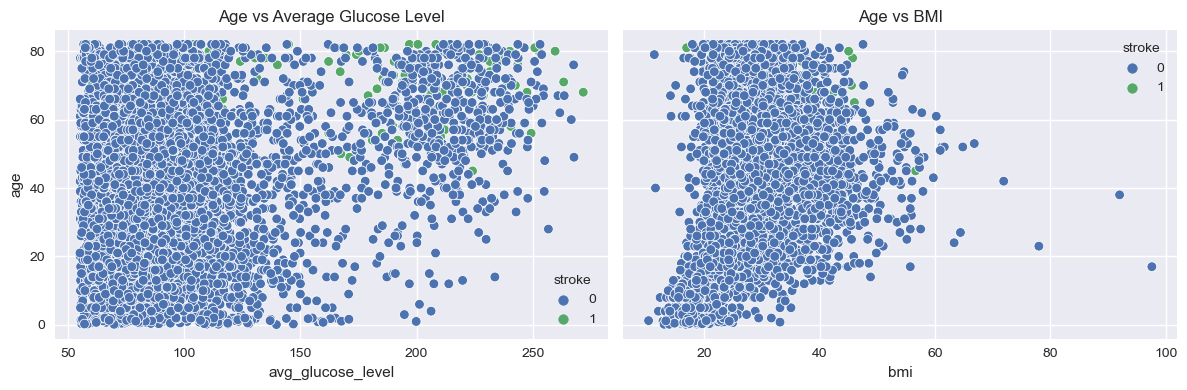

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.scatterplot(data=df_raw, y="age", x="avg_glucose_level", hue="stroke", ax=axes[0])
axes[0].set_title("Age vs Average Glucose Level")

sns.scatterplot(data=df_raw, y="age", x="bmi", hue="stroke", ax=axes[1])
axes[1].set_title("Age vs BMI")

plt.tight_layout()
plt.show()

Ave no stroke bmi: 28.82
Ave stroke bmi: 30.47


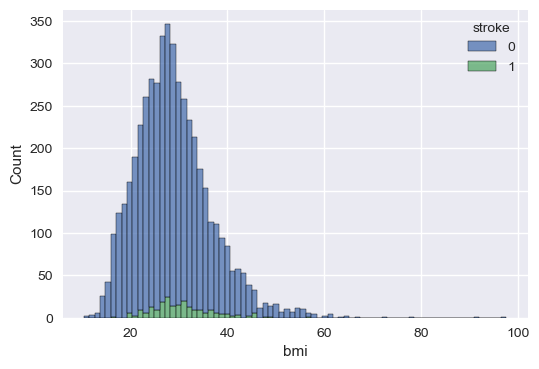

In [25]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df_raw, x="bmi", hue="stroke", multiple="stack")
print(
    f"Ave no stroke bmi: {df_raw[df_raw['stroke'] == 0].bmi.mean():.2f}\nAve stroke bmi: {df_raw[df_raw['stroke'] == 1].bmi.mean():.2f}"
)
plt.show()

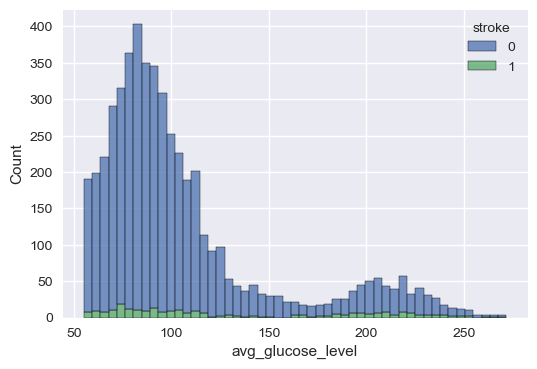

In [26]:
plt.figure(figsize=(6, 4))
sns.histplot(df_raw, x="avg_glucose_level", hue="stroke", multiple="stack")
plt.show()

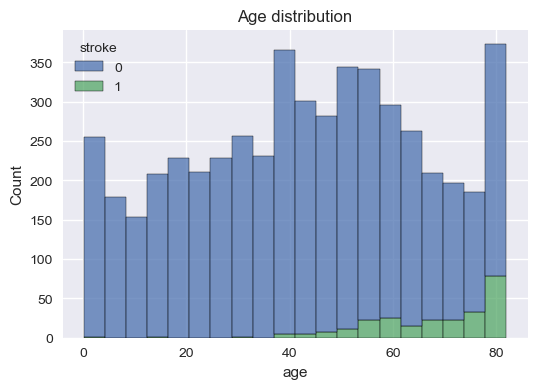

In [27]:
plt.figure(figsize=(6, 4))
sns.histplot(df_raw, x="age", hue="stroke", multiple="stack")
plt.title("Age distribution")
plt.show()

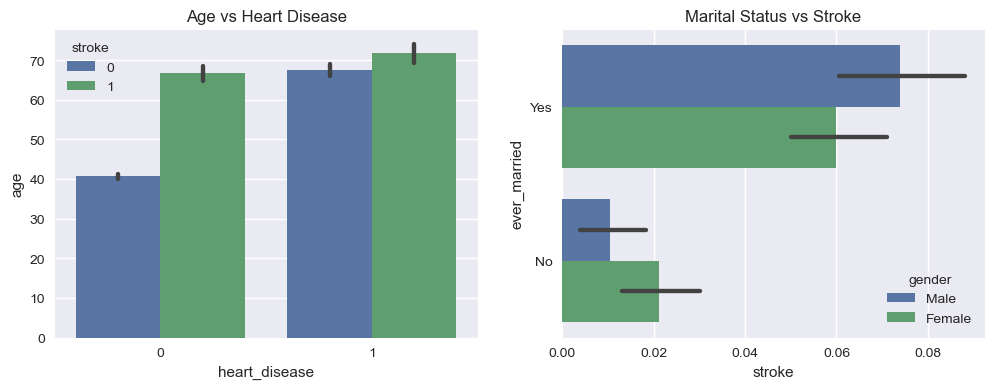

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=df_raw, x="heart_disease", y="age", hue="stroke", ax=axes[0])
axes[0].set_title("Age vs Heart Disease")

df_raw.iloc[3116, 0] = "Female"
sns.barplot(data=df_raw, x="stroke", y="ever_married", hue="gender", ax=axes[1])
axes[1].set_title("Marital Status vs Stroke")

plt.show()

# Preprocessing

In [29]:
# Under sampling: Remove instance  from the overrepresented class (randomly)
# Over sampling: SMOTE (Synthetic Minority Over-sampling Technique)
# Ensemble methods (Random Forest, XGBoost, etc.) are naturally robust to imbalanced data
# maybe do binning of BMI, age and glucose level

# create more features to help the model better predict stroke ??

In [30]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")

# remove ID column
df_processed = df_raw.drop(columns=['id'])

# Change only record with gender "other" to majority
df_processed.iloc[3116, 0] = "Female"

# remove records with too low age
# the data contained a lot of records with age close to 0 ??
df_processed_baseline = df_processed[df_processed.age >= 10] # baseline dataset with limited further processing
# impute missing values for BMI using median for baseline dataset:
df_processed_baseline['bmi'].fillna(df_processed_baseline['bmi'].median(), inplace=True)

# Perform Undersampling to account for data imbalance
# randomly remove 80% of the non-stroke instances
df_processed = df_processed_baseline.drop(df_processed_baseline.query("stroke == 0").sample(frac=.8).index)

# Remove extreme values for BMI
df_processed = df_processed[df_processed.bmi < 70]

# imputing missing values for BMI using KNN technique
imputer = KNNImputer(n_neighbors=5)
df_processed['bmi'] = imputer.fit_transform(df_processed[['bmi']])

# Encode categorical variables as numbers
def encode_numericals(df: pd.DataFrame) -> pd.DataFrame:
    """Encodes categorical variables as numbers"""
    df_return = df.copy()
    df_return['ever_married'] = df_return['ever_married'].replace({'Yes': 1, 'No': 0})
    df_return['work_type'] = df_return['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
    df_return['Residence_type'] = df_return['Residence_type'].replace({'Urban': 1, 'Rural': 0})
    df_return['smoking_status'] = df_return['smoking_status'].replace({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3})
    df_return['gender'] = df_return['gender'].replace({"Female": 0, "Male": 1})
    return df_return

# Encode baseline and processed datasets:
df_processed = encode_numericals(df_processed)
df_processed_baseline = encode_numericals(df_processed_baseline)

/var/folders/80/4f62t4pn0v71g_nbhwxdq7fh0000gn/T/ipykernel_18618/3049886857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed_baseline['bmi'].fillna(df_processed_baseline['bmi'].median(), inplace=True)


Distribution of classes with synthetic data:
{'not stroke': 876, 'stroke': 613}


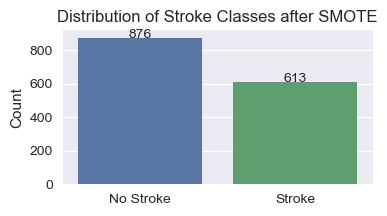

In [31]:
# SMOTE: oversampling using k-nearest neighbors to create synthetic data
oversampling_ratio = 0.7 # can only be used for binary classification
smote = SMOTE(sampling_strategy=oversampling_ratio, k_neighbors=5, random_state=rs)
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_resampled, y_resampled = smote.fit_resample(X, y)
df_processed = pd.concat([X_resampled, y_resampled], axis=1)

unique, counts = np.unique(df_processed.stroke, return_counts=True)
print("Distribution of classes with synthetic data:")
print(dict(zip(("not stroke", "stroke"), counts)))

# Stroke distribution after SMOTE
plt.figure(figsize=(4, 2))
sns.countplot(data=df_processed, x='stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])  # Change x labels
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2, p.get_height() + 15), ha='center', va='center')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of Stroke Classes after SMOTE')
plt.savefig('plots/stroke_distribution_after_smote.png', dpi=300)
plt.show()

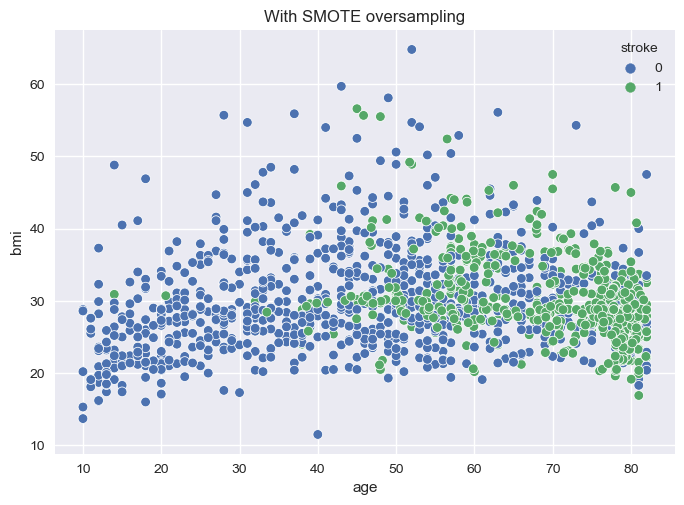

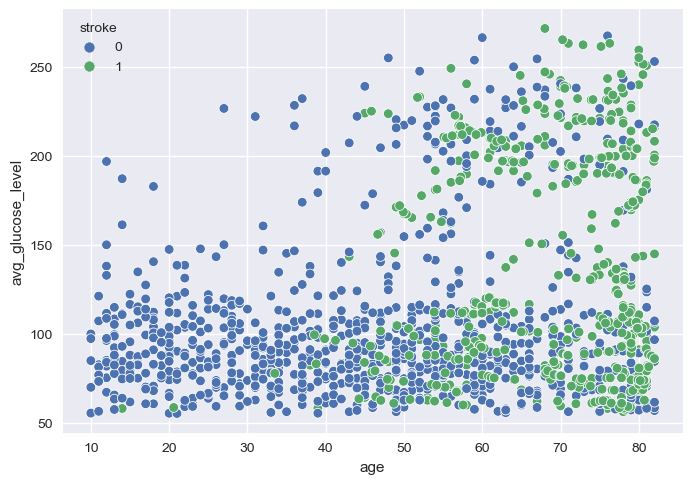

In [32]:
sns.scatterplot(data=df_processed, x="age", y="bmi", hue="stroke")
plt.title("With SMOTE oversampling")
plt.show()

sns.scatterplot(data=df_processed, x="age", y="avg_glucose_level", hue="stroke")
plt.show()

Text(0.5, 1.0, 'Pearson correlation')

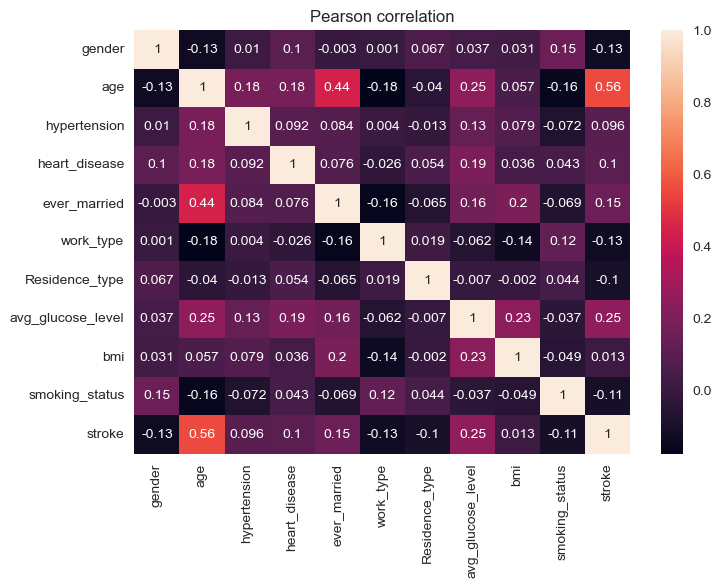

In [33]:
# make correlation plot
corr = df_processed.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")

# Model Training

In [34]:
# feature stanardisation for numerical features
scaler = StandardScaler()
df_processed[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(df_processed[['age', 'avg_glucose_level', 'bmi']])

# one hot encoding
categorical_variables = ['work_type', 'smoking_status']
df_processed = pd.get_dummies(df_processed, columns=categorical_variables, drop_first=True) # drop_first to avoid dummy variable trap.

# do not do drop first on gender since it is binary
# we do not want the model to discrimate towards genders
df_processed = pd.get_dummies(df_processed, columns=['gender'], drop_first=False)

df_processed.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3,gender_0,gender_1
0,0.600806,0,1,1,1,2.112436,0.995370,1,False,False,False,False,True,False,False,False,True
1,0.302185,0,0,1,0,1.617328,-0.192620,1,True,False,False,False,False,False,False,True,False
2,1.247816,0,1,1,0,-0.183047,0.370914,1,False,False,False,False,False,False,False,False,True
3,-0.295055,0,0,1,1,1.038082,0.660296,1,False,False,False,False,False,True,False,True,False
4,1.198046,1,0,1,0,1.092117,-0.923691,1,True,False,False,False,False,False,False,True,False


In [35]:
def encode_work(df: pd.DataFrame) -> pd.DataFrame:
    """Encodes categorical variables as numbers"""
    for col in df.columns:
        df[col] = df[col].replace({False: 0, True: 1})
    return df

df_processed = encode_work(df_processed)
df_processed

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3,gender_0,gender_1
0,0.600806,0,1,1,1,2.112436,0.995370,1,0,0,0,0,1,0,0,0,1
1,0.302185,0,0,1,0,1.617328,-0.192620,1,1,0,0,0,0,0,0,1,0
2,1.247816,0,1,1,0,-0.183047,0.370914,1,0,0,0,0,0,0,0,0,1
3,-0.295055,0,0,1,1,1.038082,0.660296,1,0,0,0,0,0,1,0,1,0
4,1.198046,1,0,1,0,1.092117,-0.923691,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,1.156273,0,0,0,0,0.275601,-1.456505,1,0,0,0,0,0,0,0,1,0
1485,1.117077,0,0,1,0,0.124782,0.129497,1,0,0,0,0,0,0,0,1,0
1486,0.529428,0,0,1,0,2.063896,-0.345059,1,0,0,0,0,0,0,0,1,0
1487,1.256445,0,0,1,0,-0.786914,-0.897285,1,0,0,0,0,0,1,0,1,0


In [36]:
age_mean, age_std = scaler.mean_[0], scaler.scale_[0]
glucose_mean, glucose_std = scaler.mean_[1], scaler.scale_[1]
bmi_mean, bmi_std = scaler.mean_[2], scaler.scale_[2]

# Make dict of means and stds for later use and save to csv file
means_stds = {"age_mean": age_mean, "age_std": age_std, "glucose_mean": glucose_mean, "glucose_std": glucose_std, "bmi_mean": bmi_mean, "bmi_std": bmi_std}
#pd.DataFrame.from_dict(means_stds, orient='index').to_csv("scaler_means_stds.csv", header=False)

import csv
with open('scaler_means_stds.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in means_stds.items():
       writer.writerow([key, value])

Random Forest model trained on non-preprocessed data:
Accuracy:  0.9482758620689655


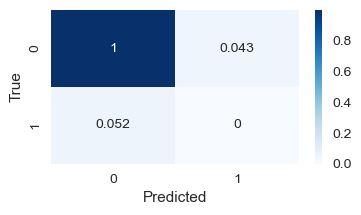

F1-score:  0.0
Precision:  0.0
Recall:  0.0
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       882
           1       0.00      0.00      0.00        46

    accuracy                           0.95       928
   macro avg       0.48      0.50      0.49       928
weighted avg       0.90      0.95      0.93       928

Random Forest model trained on preprocessed data:
Accuracy:  0.7885906040268457


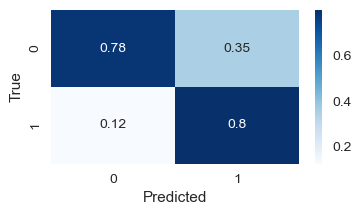

F1-score:  0.742857142857143
Precision:  0.6946564885496184
Recall:  0.7982456140350878
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       184
           1       0.69      0.80      0.74       114

    accuracy                           0.79       298
   macro avg       0.78      0.79      0.78       298
weighted avg       0.80      0.79      0.79       298

Saving model...


In [37]:
def train_rf_model(dataset, plot_name, split_ratio: float = 0.2, save: bool = False):
    X = dataset.drop(columns=["stroke"])
    y = dataset["stroke"]
    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

    # fit a random forest classifier
    clf = RandomForestClassifier(
        n_estimators=100
    )
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    # evaluate the model

    print("Accuracy: ", accuracy_score(y_test, y_pred))

    # confusion matrix
    plt.figure(figsize=(4, 2))
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    if plot_name:
        plt.savefig("plots/" + plot_name + ".png", dpi=300)
    plt.show()

    print("F1-score: ", f1_score(y_test, y_pred))
    print("Precision: " ,precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))

    print(classification_report(y_test, y_pred))
    if save:
        #save the model
        print("Saving model...")
        dump(clf, 'random_forest_model.joblib')

    return clf


# model train on non-preprocessed data (highly imbalanced data)
print("Random Forest model trained on non-preprocessed data:")
clf_baseline = train_rf_model(df_processed_baseline, plot_name="baseline_confusion_matrix")

# model trained on preprocessed data
print("Random Forest model trained on preprocessed data:")
clf = train_rf_model(df_processed, plot_name="preprocessed_confusion_matrix", split_ratio= 0.2, save=True)

# Train Simple Neural Network

In [38]:
# split data into train and test sets
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

# convert data to tensors for training
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float)

In [39]:
df_processed

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3,gender_0,gender_1
0,0.600806,0,1,1,1,2.112436,0.995370,1,0,0,0,0,1,0,0,0,1
1,0.302185,0,0,1,0,1.617328,-0.192620,1,1,0,0,0,0,0,0,1,0
2,1.247816,0,1,1,0,-0.183047,0.370914,1,0,0,0,0,0,0,0,0,1
3,-0.295055,0,0,1,1,1.038082,0.660296,1,0,0,0,0,0,1,0,1,0
4,1.198046,1,0,1,0,1.092117,-0.923691,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,1.156273,0,0,0,0,0.275601,-1.456505,1,0,0,0,0,0,0,0,1,0
1485,1.117077,0,0,1,0,0.124782,0.129497,1,0,0,0,0,0,0,0,1,0
1486,0.529428,0,0,1,0,2.063896,-0.345059,1,0,0,0,0,0,0,0,1,0
1487,1.256445,0,0,1,0,-0.786914,-0.897285,1,0,0,0,0,0,1,0,1,0


In [18]:
# simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# hyperparameters
n_features = X_train_tensor.shape[1]
input_size = n_features
hidden_size = n_features * 2
output_size = 1

# instantiate model
model = SimpleNN(input_size, hidden_size, output_size)

# loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass:
    outputs = model(X_train_tensor)
    # Compute the loss:
    loss = criterion(outputs, y_train_tensor)
    # Backward pass and optimization:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print loss every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        # calculate evaluation metrics:
        outputs = outputs.detach().numpy()
        outputs = np.where(outputs >= 0.5, 1, 0)
        print(f"Accuracy: {accuracy_score(y_train, outputs):.4f}")
        print(f"F1-score: {f1_score(y_train, outputs)}:.4f")
        print(f"Precision: {precision_score(y_train , outputs)}:.4f")
        print(f"Recall: {recall_score(y_train, outputs)}:.4f")
        print("")

print(input_size, hidden_size, output_size)
        
# save the model
print("Saving model...")
torch.save(model.state_dict(), 'neural_network_model.pth')

Epoch [500/5000], Loss: 0.5366
Accuracy: 0.7488
F1-score: 0.6725:.4f
Precision: 0.7192513368983957:.4f
Recall: 0.6314553990610329:.4f

Epoch [1000/5000], Loss: 0.4868
Accuracy: 0.7498
F1-score: 0.6889153754469607:.4f
Precision: 0.6997578692493946:.4f
Recall: 0.6784037558685446:.4f

Epoch [1500/5000], Loss: 0.4737
Accuracy: 0.7536
F1-score: 0.6944114149821641:.4f
Precision: 0.7036144578313253:.4f
Recall: 0.6854460093896714:.4f

Epoch [2000/5000], Loss: 0.4671
Accuracy: 0.7565
F1-score: 0.6983372921615203:.4f
Precision: 0.7067307692307693:.4f
Recall: 0.6901408450704225:.4f

Epoch [2500/5000], Loss: 0.4621
Accuracy: 0.7565
F1-score: 0.6997635933806148:.4f
Precision: 0.7047619047619048:.4f
Recall: 0.6948356807511737:.4f

Epoch [3000/5000], Loss: 0.4580
Accuracy: 0.7613
F1-score: 0.7053254437869823:.4f
Precision: 0.711217183770883:.4f
Recall: 0.6995305164319249:.4f

Epoch [3500/5000], Loss: 0.4543
Accuracy: 0.7641
F1-score: 0.7092198581560283:.4f
Precision: 0.7142857142857143:.4f
Recall: 0.

Accuracy:  0.7874720357941835
F1-score:  0.7425474254742549
Precision:  0.7365591397849462
Recall:  0.7486338797814208


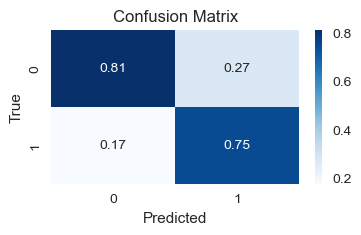

In [40]:
# Evaluate the model on the test set:
predicted_probs = model(X_test_tensor)
predicted_labels = (predicted_probs > 0.5).float()
predicted_labels = predicted_labels.detach().numpy()
print("Accuracy: ", accuracy_score(y_test, predicted_labels))
print("F1-score: ", f1_score(y_test, predicted_labels))
print("Precision: ", precision_score(y_test , predicted_labels))
print("Recall: ", recall_score(y_test, predicted_labels))

# confusion matrix
plt.figure(figsize=(4, 2))
cf_matrix = confusion_matrix(y_test, predicted_labels)
cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/nn_confusion_matrix.png", dpi=300)
plt.show()

# SHAP values demonstration

In [41]:

import shap

ModuleNotFoundError: No module named 'shap'

In [42]:
shap.initjs()
# SHAP explainability
explainer = shap.TreeExplainer(clf)

x_test_example = X_test.iloc[0]
# Calculate SHAP values for a specific instance
shap_values = explainer.shap_values(x_test_example)

shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_example)

NameError: name 'shap' is not defined